In [57]:
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import date, datetime, timedelta
from collections import Counter
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
%matplotlib inline

from sklearn import linear_model as lm
from sklearn import ensemble as ens

from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import os

In [58]:
df = pd.read_csv('data/data_with_dummies_and_class.csv')

In [59]:
keep_cols = [x for x in df.columns if 'Unnamed' not in x]
df = df[keep_cols].set_index('ID')

In [60]:
df.shape

(694192, 250)

In [61]:
features = Counter()
for col in df.columns:
    features[col.split('&')[0].strip()] += 1
features = pd.Series(features)

In [62]:
features

backers                      1
category                   159
country                     22
currency                    14
deadline_month              12
goal                         1
launched_month              12
length                       1
main_category               15
name$adj_count               1
name$caps_count              1
name$determinator_count      1
name$noun_count              1
name$possesive_count         1
name$preposition_count       1
name$punc_count              1
name$verb_count              1
name$word_count              1
pledged                      1
success                      1
usd pledged                  1
usd_pledged_real             1
dtype: int64

In [63]:
dfl = df.drop(['usd pledged', 'pledged', 'usd_pledged_real'], axis=1)

In [64]:
## drop catagory from axis (too many datapoints [159])
df_logis = dfl.drop([col for col in dfl.columns if col.split('&')[0] == 'category'], axis=1)

In [65]:
df_logis = df_logis.dropna()

In [66]:
features = Counter()
for col in df_logis.columns:
    features[col.split('&')[0].strip()] += 1
features = pd.Series(features)
features

backers                     1
country                    22
currency                   14
deadline_month             12
goal                        1
launched_month             12
length                      1
main_category              15
name$adj_count              1
name$caps_count             1
name$determinator_count     1
name$noun_count             1
name$possesive_count        1
name$preposition_count      1
name$punc_count             1
name$verb_count             1
name$word_count             1
success                     1
dtype: int64

In [67]:
## manual model
# model = ens.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# cv = pd.Series(np.random.choice(range(5), df_logis.shape[0]), index=df_logis.index)

# Xtr = df_logis.loc[cv != 0, :]
# Xte = df_logis.loc[cv == 0, :]
# ytr = Xtr.pop('success')
# yte = Xte.pop('success')

# model.fit(Xtr, ytr)

# # float((model.predict(Xte) == yte).sum()) / yte.size

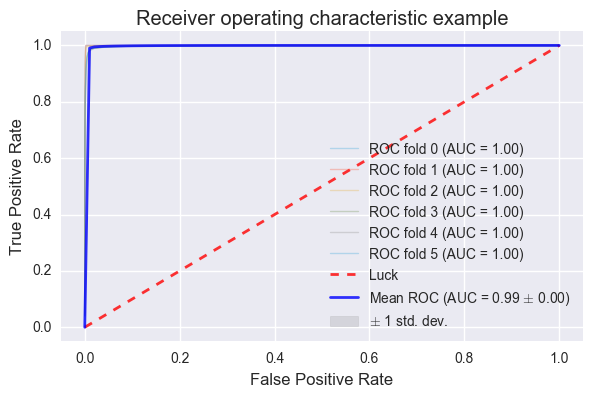

In [68]:
# #############################################################################
# Data IO and generation

# Import some data to play with
X = df_logis.copy()
y = X.pop('success')
n_samples, n_features = X.shape

# # Add noisy features
random_state = np.random.RandomState(42)
# # X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=random_state)
classifier = ens.RandomForestClassifier(n_estimators=100, 
                                        n_jobs=-1, 
                                        random_state=random_state) 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probs = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probs[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [197]:
def cv_build_model(df, y_col, nfolds=5, n_estimators=100, max_features='sqrt', 
                    criterion='gini', min_samples_leaf=1, random_state=42):
    '''
    Input Dataframe ready for analysis ouputs probabilities of y_col (y col must be binary or bool)
    --------
    PARAMETERS
    df: pd.DataFrame
        -   Must contain all numerical or bool values
    y_col: str
        -   must be a column within df and contain only either binary or bool values
    nfolds: int (default 5):
        -   number of times to split dataframe between train and test sets (min value should be 3)
    n_estimators: int:
        -   Number of decision trees to generate out of the dataset
    max_features: str ('sqrt' | 'log2' | 'None' ) {default= 'sqrt'}
        -   Max number of features allowed in one individual estimator
    criterion: str ('gini' | 'entropy' ) {default=  'gini'}
        -   Function used to determine information gain from a split
    min_samples_leaf: int default(1)
        -   the minimum number of samples in a final terminus for the decision tree
    random_state: int {default= 42}
        -   random seed for decision tree feature selection and bootstrap 
    --------
    RETURNS
    prob_folds, atcual: tuple (list of np.array dtype=float, list of np.array dtype=bool)
        -   prob_folds contains the probability that a given value in the test_set is equal to 1
        -   atcual contains the atcual value for that datapoint
    '''
    X = df.copy()
    y = X.pop(y_col)
    n_samples, n_features = X.shape
    ## Define random seed
    random_state = np.random.RandomState(random_state)
    # Run classifier with cross-validation 
    cv = StratifiedKFold(nfolds)
    classifier = ens.RandomForestClassifier(n_estimators=n_estimators,
                                            max_features=max_features, 
                                            bootstrap=True,
                                            n_jobs=-1,
                                            criterion=criterion,
                                            min_samples_leaf= min_samples_leaf,
                                            random_state=random_state) 
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    prob_folds = []
    atcual = []
    for train, test in cv.split(X, y):
        prob_folds.append(classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test]))
        atcual.append(y.iloc[test])
    return prob_folds[:,1], atcual

def find_auc(probs, atcual):
    '''
    Identify Area under ROC curve for a specific model
    --------
    PARAMETERS
    probs: np.array dtype= float
        -   probability of the value being True
    atcual np.array dtype= bool or int
        -   Atcual value of predictor variable as a bool or binary integer
    --------
    RETURNS (tuple with 3 values)
    roc_auc: float
        -   area under the curve for the given model
    fpr:
        -   ratio of atcual false values which were predicted true
    tpr:
        -   ratio of atcual true values predicted correctly
    '''
    fpr, tpr, thresholds = roc_curve(atcual, probs)
#     fpr, tpr, thresholds = roc_curve(y.iloc[test], probs[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def plot_auc(folds):
    '''
    poop
    --------
    PARAMETERS list of folds - (fpr, tpr, roc_auc)
    folds: list of indeterminite length tuples containing (fpr: array, tpr: array, roc_auc: float)
        * tpr: array dtype= float
            -   ratio of positive values predicted positive by the model
        * fpr: array dtype= float
            -   ratio of positive values predicted negative by the model
        * roc_auc: float
            -   area under the ROC curve
    '''
    i=0
    for fpr, tpr, roc_auc in folds:
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Luck', alpha=.8)
    mean_tpr = np.array([np.mean(i) for i in zip(*[t[1] for t in folds])])
    mean_fpr = np.array([np.mean(i) for i in zip(*[t[0] for t in folds])])
    std_tpr = np.array([np.std(i) for i in zip(*[t[1] for t in folds])])
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std([i[2] for i in folds])
    print mean_auc 
    print std_auc
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [138]:
# validate_model(df_logis, 'success')

In [95]:
prob_folds, atcual = cv_build_model(df_logis, 'success')

In [120]:
tup = find_auc(prob_folds[0][:,1], atcual[0])

In [148]:
for i in tup:
    print i[2]

0.999676115967
0.999746353284
0.998903542445
0.998299150686
0.998517627393


0.425670853819
0.000590470218301


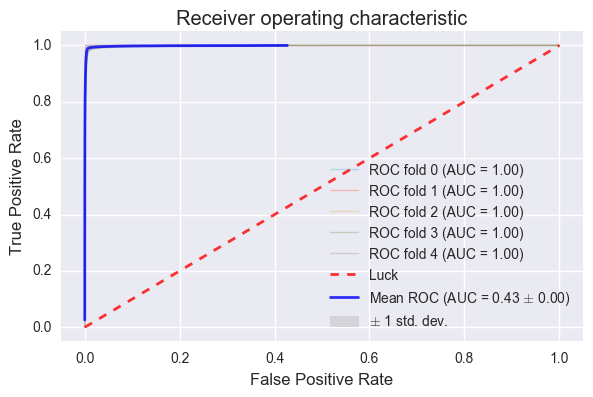

In [198]:
plot_auc(tup)

In [162]:
np.array([list(t[1]) for t in tup]).shape

(5,)

In [171]:
np.mean(zip(*[t[1] for t in tup]))

0.90460938791842149

In [172]:
np.mean(zip(*[t[0] for t in tup]))

0.040695005995964074

In [180]:
np.std([t[2] for t in tup])

0.0005904702183009646

In [179]:
[np.mean(i) for i in zip(*[t[1] for t in tup])]

[0.025868285652117649,
 0.094071460151886194,
 0.1881548326543083,
 0.26711406993708497,
 0.34092369728586447,
 0.42840671249212836,
 0.49243405446027982,
 0.53665652442079925,
 0.59736562183756603,
 0.6249851493304257,
 0.66341676181344966,
 0.69311210206733342,
 0.72075161005738464,
 0.7384606333997723,
 0.7604215578241591,
 0.7794450074043906,
 0.79113481496775839,
 0.80836285921020001,
 0.81771631153474167,
 0.83160218976317712,
 0.84329999480916451,
 0.84940739850260871,
 0.85993902612291317,
 0.86678379265496341,
 0.87884225184631892,
 0.88426036022561616,
 0.892331400332804,
 0.89724857111717482,
 0.90430572306802193,
 0.90840937863016147,
 0.91662067207439202,
 0.92403447914824777,
 0.93071492160285685,
 0.93623320219595141,
 0.93934700661613169,
 0.94319417388895754,
 0.94698523672738466,
 0.94921338998917748,
 0.95374182104631333,
 0.95658712172139082,
 0.95951256898445059,
 0.96303111901790994,
 0.96358014621980692,
 0.9665977590598398,
 0.9696554514171174,
 0.97137865657871